# **1. Alien vs Predator Îç∞Ïù¥ÌÑ∞ÏÖã**

In [2]:
from google.colab import files
files.upload()  # kaggle.json ÏóÖÎ°úÎìú Ï∞Ω ÌëúÏãú
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images

Dataset URL: https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images
License(s): ODbL-1.0
  0% 0.00/14.1M [00:00<?, ?B/s]
100% 14.1M/14.1M [00:00<00:00, 915MB/s]


In [4]:
!unzip -q alien-vs-predator-images.zip

# **2. Alexnet Î™®Îç∏ÏùÑ ÌôúÏö©Ìïú Alien vs Predator Î∂ÑÎ•ò**

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [9]:
# Ï†ÑÏ≤òÎ¶¨

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Î™®Îì† Ïù¥ÎØ∏ÏßÄÎ•º 224x224 ÌÅ¨Í∏∞Î°ú Í≥†Ï†ï
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # Affine Î≥ÄÌôò (ÌöåÏ†ÑÏùÄ ÏóÜÏùå, Í∏∞Ïö∏Í∏∞(shear), ÌÅ¨Í∏∞(scale)Îßå ÎûúÎç§ Î≥ÄÌòï)
        transforms.RandomHorizontalFlip(),  # Ï¢åÏö∞Î∞òÏ†ÑÏùÑ ÎûúÎç§ÏúºÎ°ú Ï†ÅÏö©
        transforms.ToTensor()  # PIL Ïù¥ÎØ∏ÏßÄÎ•º PyTorch ÌÖêÏÑúÎ°ú Î≥ÄÌôò (Í∞í Î≤îÏúÑ: 0~1)
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

# ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏóêÎäî Îç∞Ïù¥ÌÑ∞ Ï¶ùÍ∞ï(Data Augmentation) ÏùÑ Ï†ÅÏö©ÌïòÏó¨ Î™®Îç∏Ïù¥ Îã§ÏñëÌïú ÏÉÅÌô©Ïóê Ïûò ÏùºÎ∞òÌôîÎêòÎèÑÎ°ù ÎèÑÏôÄÏ§ÄÎã§.
# Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏóêÎäî Ïò§ÏßÅ ÌÅ¨Í∏∞ Ï°∞Ï†ï(Resize) Í≥º Tensor Î≥ÄÌôòÎßå Ï†ÅÏö©ÌïòÏó¨ ÏòàÏ∏° ÏÑ±Îä•Îßå ÌèâÍ∞ÄÌïúÎã§.

In [11]:
def target_transforms(target):
    return torch.FloatTensor([target])

- target : Ï†ïÎãµÍ∞í(label)
- [target] : Ï†ïÎãµÏùÑ Î¶¨Ïä§Ìä∏ ÌòïÌÉúÎ°ú Í∞êÏã∏Í∏∞ -> [0] ÎòêÎäî [1]
- torch.FloatTensor(...) : Ìï¥Îãπ Î¶¨Ïä§Ìä∏Î•º FloatTensorÎ°ú Î≥ÄÌôò -> tensor([0.]) ÎòêÎäî tensor([1.])


‚úÖ Ïôú Ïù¥Î†áÍ≤å Ïì∞ÎÇòÏöî?

ÏùºÎ∞òÏ†ÅÏúºÎ°ú ImageFolder Í∞ôÏùÄ Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú labelÏùÄ int (Ïòà: 0, 1) ÌòïÏãùÏûÖÎãàÎã§.

ÌïòÏßÄÎßå ÌöåÍ∑Ä Î¨∏Ï†ú, ÌòπÏùÄ BCELoss (Binary Cross Entropy Loss) Í∞ôÏùÄ Í≤ΩÏö∞, labelÏù¥ float ÌÖêÏÑú ÌòïÏãùÏù¥Í∏∞Î•º Í∏∞ÎåÄÌï©ÎãàÎã§.

Ïòà: BCELossÎäî targetÏù¥ FloatTensorÏù¥Í≥† Í∞íÏù¥ [0.] ÎòêÎäî [1.] ÌòïÌÉúÏù¥Í∏∏ ÏõêÌï©ÎãàÎã§.

In [12]:
# Ïù¥ÎØ∏ÏßÄ Î∂ÑÎ•òÏö© Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±

image_datasets = {
    'train': datasets.ImageFolder('data/train', data_transforms['train'],
                                  target_transform = target_transforms),
    'validation': datasets.ImageFolder('data/validation', data_transforms['validation'],
                                       target_transform=target_transforms)
}

- transform(ÏûÖÎ†• Ï†ÑÏ≤òÎ¶¨), target_transform(Ï†ïÎãµÍ∞í Ï†ÑÏ≤òÎ¶¨) Ï†ÅÏö©
- datasets.ImageFolder(): ÎîîÎ†âÌÑ∞Î¶¨ Íµ¨Ï°∞Ïóê Îî∞Îùº Ïù¥ÎØ∏ÏßÄÏôÄ Î†àÏù¥Î∏îÏùÑ ÏûêÎèôÏúºÎ°ú Î∂àÎü¨Ïò§Îäî ÌÅ¥ÎûòÏä§
    - glass = ÌÅ¥ÎûòÏä§0
    - noglass = ÌÅ¥ÎûòÏä§1
- transform=data_transforms['train'] : ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄÏóê Ï†ÅÏö©Ìï† Ï†ÑÏ≤òÎ¶¨ Ìï®Ïàò
- target_transform=target_transforms : Ï†ïÎãµ(label)Ïóê Ï†ÅÏö©Ìï† Ï†ÑÏ≤òÎ¶¨ Ìï®Ïàò

‚ãá target_transforms : Ï†ïÎãµ(label)ÏùÑ tensor([0.]) ÎòêÎäî tensor([1.]) ÌòïÌÉúÏùò FloatTensorÎ°ú Î≥ÄÌôò

In [14]:
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size = 32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

len(image_datasets['train']), len(image_datasets['validation'])

(694, 200)

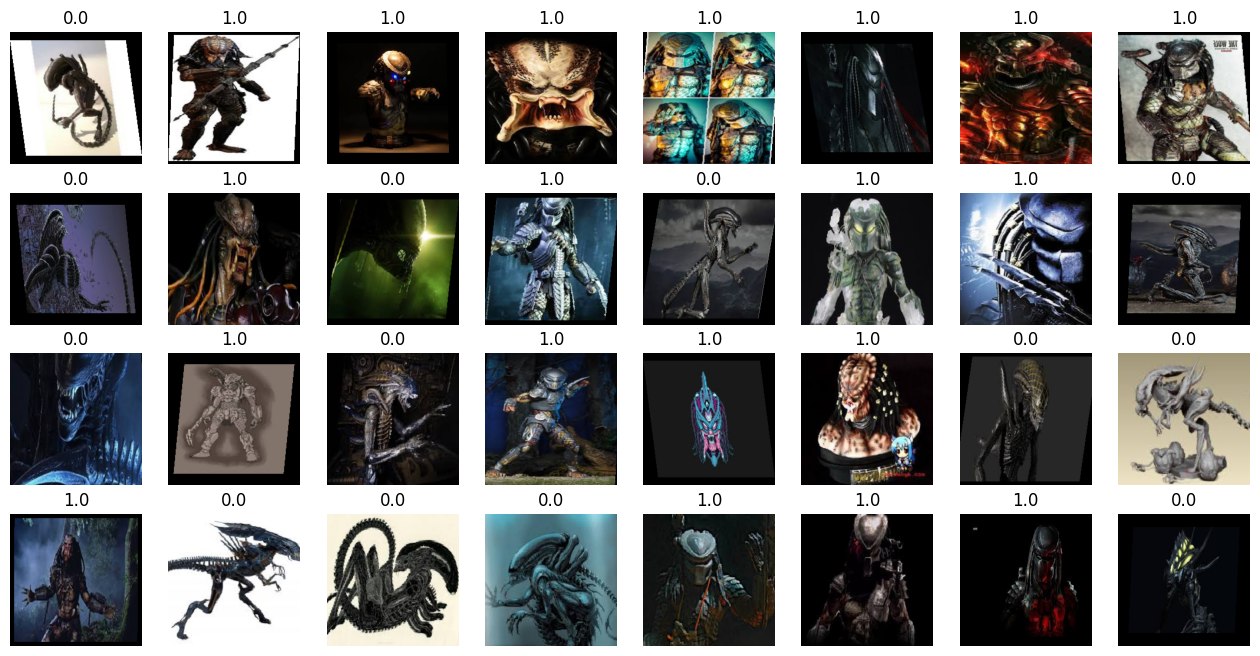

In [15]:
# Î∞∞ÏπòÏóêÏÑú Ï≤´ Î≤àÏß∏ Î¨∂Ïùå Í∫ºÎÇ¥Í∏∞
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.permute(1, 2, 0)) # (3, 224, 224) -> (224, 224, 3)
    ax.set_title(label.item())
    ax.axis('off')

- dataloaders['train']: ÌïôÏäµÏö© DataLoader Í∞ùÏ≤¥ (batch Îã®ÏúÑÎ°ú Ïù¥ÎØ∏ÏßÄ + ÎùºÎ≤® Ï†úÍ≥µ)
- iter(...) : Ïù¥ÌÑ∞Î†àÏù¥ÌÑ∞Î°ú Î≥ÄÌôò
- next(...) : Ï≤´ Î≤àÏß∏ Î∞∞ÏπòÎ•º Í∫ºÎÉÑ(Ìïú Î≤àÎßå Í∞ÄÏ†∏Ïò¥)
- imgs : Ïù¥ÎØ∏ÏßÄ ÌÖêÏÑú(batch_size, C, H, W)


# **3. Ï†ÑÏù¥ÌïôÏäµ**
Ï†ÑÏù¥ ÌïôÏäµ(Transfer Learning)ÏùÄ Ïù¥ÎØ∏ ÌïôÏäµÎêú Î™®Îç∏(Ï£ºÎ°ú ÎåÄÍ∑úÎ™® Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú ÏÇ¨Ï†Ñ ÌïôÏäµÎêú Îî•Îü¨Îãù Î™®Îç∏)ÏùÑ ÏÉàÎ°úÏö¥ Î¨∏Ï†úÏóê Ï†ÅÏö©ÌïòÏó¨ ÌïôÏäµ ÏãúÍ∞ÑÏùÑ Îã®Ï∂ïÌïòÍ≥† ÏÑ±Îä•ÏùÑ Ìñ•ÏÉÅÏãúÌÇ§Îäî Î∞©Î≤ïÏûÖÎãàÎã§. Í∏∞Ï°¥ Î™®Îç∏Ïù¥ ÌïôÏäµÌïú ÌäπÏßï(Feature)ÏùÑ ÌôúÏö©Ìï¥, ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú Î™®Îç∏Ïùò ÏùºÎ∂Ä(Ï£ºÎ°ú ÎßàÏßÄÎßâ Î†àÏù¥Ïñ¥)Îßå Îã§Ïãú ÌïôÏäµÌïòÍ±∞ÎÇò Ï∂îÍ∞Ä ÌïôÏäµ(Fine-tuning)ÏùÑ ÏßÑÌñâÌï©ÎãàÎã§. Ïù¥Îäî ÌäπÌûà Îç∞Ïù¥ÌÑ∞Í∞Ä Ï†ÅÍ±∞ÎÇò ÌïôÏäµ Î¶¨ÏÜåÏä§Í∞Ä Ï†úÌïúÎêú ÏÉÅÌô©ÏóêÏÑú Ìö®Í≥ºÏ†ÅÏù¥Î©∞, Ïù¥ÎØ∏ÏßÄ Î∂ÑÎ•ò(Ïòà: ResNet, VGG), ÏûêÏó∞Ïñ¥ Ï≤òÎ¶¨(Ïòà: BERT, GPT) Îì± Îã§ÏñëÌïú Î∂ÑÏïºÏóêÏÑú ÎÑêÎ¶¨ ÏÇ¨Ïö©Îê©ÎãàÎã§.   (Ïù¥ÎØ∏ ÌïôÏäµÎêú Í∞ÄÏ§ëÏπòÎ•º Îã§Î•∏ Í≥≥ÏóêÏÑú ÏÇ¨Ïö©ÌïòÎäî Í≤É)

In [16]:
model = models.alexnet(weights='IMAGENET1K_V1').to(device)
print(model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 233M/233M [00:01<00:00, 149MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

- models.alexnet(): AlexNet Íµ¨Ï°∞ ÏÉùÏÑ±
- weights='IMAGENET1K_V1': ÏÇ¨Ï†Ñ ÌïôÏäµÎêú ImageNet Í∞ÄÏ§ëÏπò ÏÇ¨Ïö©
- .to(device) : Î™®Îç∏ÏùÑ CPU ÎòêÎäî GPUÎ°ú Ïù¥Îèô
- Ïö©ÎèÑ: Ï†ÑÏù¥ÌïôÏäµ ÎòêÎäî feature extraction

‚Äª Ïù¥ÎØ∏ÏßÄÎÑ∑

Ïù¥ÎØ∏ÏßÄÎÑ∑(ImageNet)ÏùÄ ÎåÄÍ∑úÎ™® Ïù¥ÎØ∏ÏßÄ Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú, Ïª¥Ìì®ÌÑ∞ ÎπÑÏ†Ñ Ïó∞Íµ¨ÏôÄ Îî•Îü¨Îãù Î™®Îç∏ ÌïôÏäµÏóê ÎÑêÎ¶¨ ÏÇ¨Ïö©Îê©ÎãàÎã§. 2009ÎÖÑ Ïä§ÌÉ†Ìè¨Îìú ÎåÄÌïôÏùò ÌéòÏù¥ÌéòÏù¥ Î¶¨(Fei-Fei Li) ÍµêÏàòÌåÄÏù¥ Íµ¨Ï∂ïÌñàÏúºÎ©∞, ÏïΩ 1,400Îßå Ïû•Ïùò Ïù¥ÎØ∏ÏßÄÏôÄ 22,000Í∞ú Ïù¥ÏÉÅÏùò Ïπ¥ÌÖåÍ≥†Î¶¨Î°ú Íµ¨ÏÑ±ÎêòÏñ¥ ÏûàÏäµÎãàÎã§. Ïù¥ Ï§ë, Í∞ÄÏû• ÎÑêÎ¶¨ ÏÇ¨Ïö©ÎêòÎäî ILSVRC(Imagenet Large Scale Visual Recognition Challenge) Î≤ÑÏ†ÑÏùÄ ÏïΩ 1,000Í∞úÏùò ÌÅ¥ÎûòÏä§ÏôÄ 120Îßå Ïû•Ïùò Ïù¥ÎØ∏ÏßÄÎ•º Ìè¨Ìï®Ìï©ÎãàÎã§. Ïù¥ÎØ∏ÏßÄÎÑ∑ÏùÄ Î™®Îç∏Ïù¥ Í∞ùÏ≤¥Î•º Î∂ÑÎ•òÌïòÍ≥† ÌäπÏßïÏùÑ ÌïôÏäµÌïòÎäî Îç∞ ÌïÑÏöîÌïú ÌíçÎ∂ÄÌïú Îç∞Ïù¥ÌÑ∞ÏôÄ Î†àÏù¥Î∏îÏùÑ Ï†úÍ≥µÌïòÎ©∞, ResNet, VGG, Inception Îì± Ïó¨Îü¨ ÌòÅÏã†Ï†ÅÏù∏ Î™®Îç∏Ïù¥ Ïù¥ÎØ∏ÏßÄÎÑ∑ ÎåÄÌöåÎ•º ÌÜµÌï¥ Í∞úÎ∞úÎêòÏóàÏäµÎãàÎã§. Ïù¥ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÄ ÌäπÌûà ÏÇ¨Ï†Ñ ÌïôÏäµ(Transfer Learning)ÏóêÏÑú Ï§ëÏöîÌïú Ïó≠Ìï†ÏùÑ ÌïòÎ©∞, Îî•Îü¨Îãù Ïó∞Íµ¨Ïùò ÌëúÏ§Ä Î≤§ÏπòÎßàÌÅ¨Î°ú ÏûêÎ¶¨ Ïû°ÏïòÏäµÎãàÎã§.

In [17]:
for param in model.parameters():
    param.requires_grad = False   # Í∞ÄÏ†∏Ïò® ÌååÎùºÎØ∏ÌÑ∞Î•º ÏóÖÎç∞Ïù¥Ìä∏ ÌïòÏßÄ ÏïäÏùå.(Í≥†Ï†ï, freezeÏãúÌÇ¥.)

‚Äª Model Freezing

Model FreezingÏùÄ Ï†ÑÏù¥ ÌïôÏäµ(Transfer Learning)ÏóêÏÑú ÏÇ¨Ï†Ñ ÌïôÏäµÎêú Î™®Îç∏Ïùò ÏùºÎ∂Ä ÎòêÎäî Ï†ÑÏ≤¥ Í≥ÑÏ∏µÏùò Í∞ÄÏ§ëÏπòÎ•º Í≥†Ï†ïÌïòÏó¨ ÌïôÏäµÎêòÏßÄ ÏïäÎèÑÎ°ù ÏÑ§Ï†ïÌïòÎäî Í∏∞Î≤ïÏûÖÎãàÎã§. Ï£ºÎ°ú ÏÇ¨Ï†Ñ ÌïôÏäµÎêú Î™®Îç∏Ïùò Ï¥àÍ∏∞ Í≥ÑÏ∏µ(Convolutional Layers Îì±)ÏùÄ ÏùºÎ∞òÏ†ÅÏù∏ ÌäπÏßï(Ïòà: Í∞ÄÏû•ÏûêÎ¶¨, Ìå®ÌÑ¥)ÏùÑ ÌïôÏäµÌñàÏúºÎØÄÎ°ú Í≥†Ï†ïÌïòÍ≥†, ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞ÏÖãÏóê ÌäπÌôîÎêú ÌäπÏßïÏùÑ ÌïôÏäµÌïòÍ∏∞ ÏúÑÌï¥ ÏµúÏÉÅÏúÑ Í≥ÑÏ∏µ(Î∂ÑÎ•ò Ìó§Îìú Îì±)Îßå ÌïôÏäµÌï©ÎãàÎã§. Ïù¥ Î∞©Î≤ïÏùÄ ÌïôÏäµÌï† Í∞ÄÏ§ëÏπòÏùò ÏàòÎ•º Ï§ÑÏó¨ **Í≥ÑÏÇ∞ ÎπÑÏö©ÏùÑ Ï†àÍ∞êÌïòÍ≥†, Í≥ºÏ†ÅÌï©ÏùÑ Î∞©ÏßÄÌïòÎ©∞, Îç∞Ïù¥ÌÑ∞Í∞Ä Î∂ÄÏ°±Ìïú ÏÉÅÌô©ÏóêÏÑú ÌäπÌûà Ïú†Ïö©**Ìï©ÎãàÎã§. ÌïÑÏöîÏóê Îî∞Îùº, Ï¥àÍ∏∞ ÌïôÏäµÏù¥ ÎÅùÎÇú ÌõÑ ÏùºÎ∂Ä Í≥ÑÏ∏µÏùÑ Í≥†Ï†ï Ìï¥Ï†ú(Fine-Tuning)ÌïòÏó¨ Î™®Îç∏ÏùÑ Îçî Ï†ïÍµêÌïòÍ≤å Ï°∞Ï†ïÌï† ÏàòÎèÑ ÏûàÏäµÎãàÎã§.

In [18]:
# Ïù¥ÏßÑ Î∂ÑÎ•ò(glass vs no glass) Ïö© Î∂ÑÎ•òÍ∏∞ Íµ¨Ï°∞ ÏÑ§Ï†ï (Ï†ÑÏù¥ ÌïôÏäµÏö©)

model.classifier = nn.Sequential(
    nn.Linear(256 * 6 * 6, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_featur

- nn.Linear(256 * 6 * 6, 128)
    - ÏûÖÎ†•: AlexNetÏùò ÎßàÏßÄÎßâ convolution layer Ï∂úÎ†• ÌÅ¨Í∏∞ (256 x 6 x 6)

    - Ï∂úÎ†•: 128Ï∞®ÏõêÏúºÎ°ú ÏïïÏ∂ïÎêú Î≤°ÌÑ∞

üí° AlexNetÏùò feature extractorÎäî Í≥†Ï†ïÎêú ÏûÖÎ†•(224x224) Í∏∞Ï§ÄÏúºÎ°ú Ìï≠ÏÉÅ (256, 6, 6) ÌÅ¨Í∏∞Ïùò ÌÖêÏÑúÎ•º Ï∂úÎ†•Ìï©ÎãàÎã§.

- nn.ReLU() ÌôúÏÑ±Ìôî Ìï®Ïàò: ÎπÑÏÑ†ÌòïÏÑ± Ï∂îÍ∞Ä

- nn.Linear(128, 1)
    - Ï∂úÎ†•Ï∏µ: Îã® ÌïòÎÇòÏùò Ïä§ÏπºÎùº Í∞í
    - Ïù¥ Í∞íÏùÄ "1Ïùº ÌôïÎ•†" ÎòêÎäî "positive classÏùº ÌôïÎ•†" ÏùÑ ÏùòÎØ∏

- nn.Sigmoid()
    - Ï∂úÎ†•Í∞íÏùÑ 0~1 ÏÇ¨Ïù¥Ïùò ÌôïÎ•† Í∞íÏúºÎ°ú Î≥ÄÌôò


```
Input (batch x 3 x 224 x 224)
   ‚Üì
AlexNet feature extractor (conv layers)
   ‚Üì
Flatten ‚Üí (batch x 256*6*6)
   ‚Üì
Linear(9216 ‚Üí 128)
   ‚Üì
ReLU
   ‚Üì
Linear(128 ‚Üí 1)
   ‚Üì
Sigmoid ‚Üí ÌôïÎ•†Í∞í Ï∂úÎ†• (Ïòà: 0.87 ‚Üí "glass")
```

In [19]:
# ÌïôÏäµ

# ÏòµÌã∞ÎßàÏù¥Ï†Ä ÏÑ§Ï†ï
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


# ÌïôÏäµ Î∞òÎ≥µ
epochs = 10

for epoch in range(epochs):

    # trainÍ≥º validation Î∞òÎ≥µ Ï≤òÎ¶¨
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_losses = 0
        sum_accs = 0

        # Î∞∞Ïπò Ï≤òÎ¶¨ : DataLoaderÎ•º ÌÜµÌï¥ ÎØ∏ÎãàÎ∞∞Ïπò Îã®ÏúÑÎ°ú Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨Ïò®Îã§.
        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # ÏòàÏ∏° Î∞è ÏÜêÏã§ Í≥ÑÏÇ∞
            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)

            # ÌïôÏäµ Îã®Í≥ÑÏùº Í≤ΩÏö∞: Ïó≠Ï†ÑÌåå Î∞è ÏµúÏ†ÅÌôî
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses += loss

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs += acc

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.4f} Accuracy: {avg_acc:.2f}%')


train     : Epoch    1/10 Loss: 0.4791 Accuracy: 75.03%
validation: Epoch    1/10 Loss: 0.3745 Accuracy: 81.25%
train     : Epoch    2/10 Loss: 0.2321 Accuracy: 91.06%
validation: Epoch    2/10 Loss: 0.4867 Accuracy: 79.46%
train     : Epoch    3/10 Loss: 0.2175 Accuracy: 90.35%
validation: Epoch    3/10 Loss: 0.2931 Accuracy: 86.16%
train     : Epoch    4/10 Loss: 0.1440 Accuracy: 95.11%
validation: Epoch    4/10 Loss: 0.1919 Accuracy: 91.96%
train     : Epoch    5/10 Loss: 0.1288 Accuracy: 94.77%
validation: Epoch    5/10 Loss: 0.3385 Accuracy: 85.27%
train     : Epoch    6/10 Loss: 0.1397 Accuracy: 94.40%
validation: Epoch    6/10 Loss: 0.2139 Accuracy: 88.39%
train     : Epoch    7/10 Loss: 0.0859 Accuracy: 97.17%
validation: Epoch    7/10 Loss: 0.2553 Accuracy: 87.50%
train     : Epoch    8/10 Loss: 0.0870 Accuracy: 97.16%
validation: Epoch    8/10 Loss: 0.2637 Accuracy: 87.50%
train     : Epoch    9/10 Loss: 0.0823 Accuracy: 96.81%
validation: Epoch    9/10 Loss: 0.1798 Accuracy:

```
[ÌïôÏäµ Ï§ÄÎπÑ] ‚Üí [ÏóêÌè¨ÌÅ¨ Î∞òÎ≥µ] ‚Üí [ÌïôÏäµÍ≥º Í≤ÄÏ¶ùÏùÑ Î∞òÎ≥µ] ‚Üí [ÏÜêÏã§ Î∞è Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞] ‚Üí [Ï∂úÎ†•]
```

In [20]:
from PIL import Image

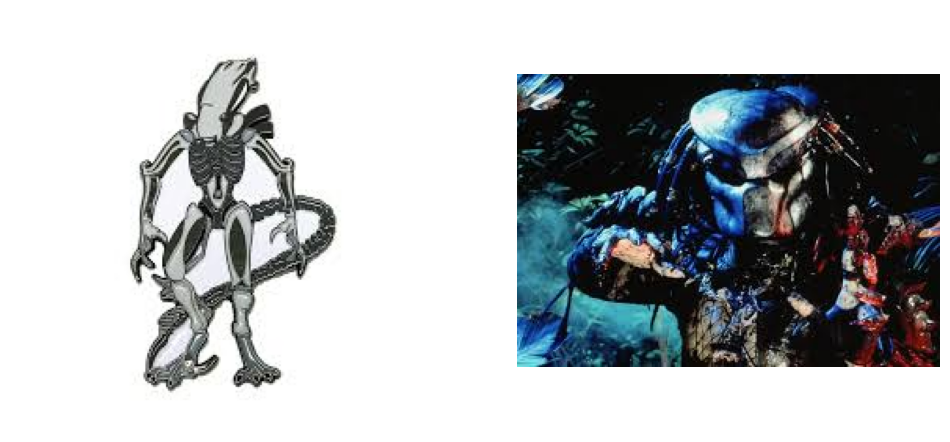

In [21]:
img1 = Image.open('/content/data/train/alien/0.jpg')
img2 = Image.open('/content/data/train/predator/0.jpg')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')  # Ï∂ï ÎààÍ∏à(ÌÖåÎëêÎ¶¨ Î∞è Ï¢åÌëú)ÏùÑ Ï†úÍ±∞
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [22]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [23]:
test_batch = torch.stack([img1_input, img2_input])
# img1_input, img2_inputÏùÄ torch.Tensor ÌòïÏãùÏù¥Î©∞, Î≥¥ÌÜµ [C, H, W] Íµ¨Ï°∞.
# Ïòà: img1_input.shape = torch.Size([3, 224, 224])
# torch.stack([...]): Îëê Ïù¥ÎØ∏ÏßÄÎ•º ÌïòÎÇòÏùò Î∞∞Ïπò(batch)Î°ú Ìï©ÏπúÎã§.
test_batch = test_batch.to(device)
test_batch.shape
# 2Ïû•(batch size = 2) Ïùò RGB Ïù¥ÎØ∏ÏßÄÎ°ú Íµ¨ÏÑ±Îêú 4Ï∞®Ïõê ÌÖêÏÑú

# Îî•Îü¨Îãù Î™®Îç∏ÏùÄ Î∞∞Ïπò Îã®ÏúÑ ÏûÖÎ†•ÏùÑ Í∏∞ÎåÄÌïòÎØÄÎ°ú, ÌïòÎÇò Ïù¥ÏÉÅÏùò Ïù¥ÎØ∏ÏßÄÎ•º torch.stack()ÏúºÎ°ú Î¨∂Îäî Í≤ÉÏù¥ ÌïÑÏàò

torch.Size([2, 3, 224, 224])

In [24]:
y_pred = model(test_batch)
y_pred

tensor([[3.6411e-04],
        [1.0000e+00]], grad_fn=<SigmoidBackward0>)

(np.float64(-0.5), np.float64(269.5), np.float64(186.5), np.float64(-0.5))

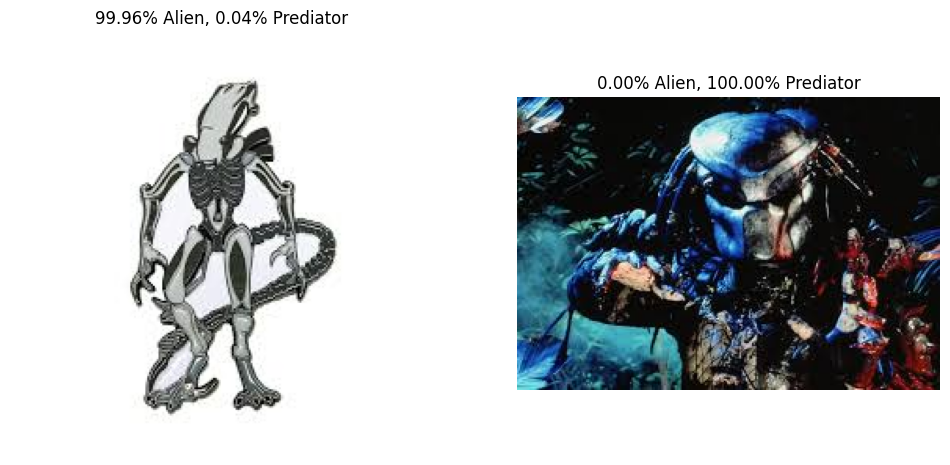

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title(f'{(1-y_pred[0, 0])*100:.2f}% Alien, {(y_pred[0, 0])*100:.2f}% Prediator')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1, 0])*100:.2f}% Alien, {(y_pred[1, 0])*100:.2f}% Prediator')
axes[1].imshow(img2)
axes[1].axis('off')